<a href="https://colab.research.google.com/github/jphaugh/Bioinformatics-FinalProject/blob/main/Updated-ProjectPythonCode-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Combining Old World MHC gene FAA files (from NCBI datasets terminal code) into one file.

In [ ]:
combined_content = ""
file_names = ['NewGreenProtein.faa', 'NewHumanProtein.faa', 'NewMacaqueProtein.faa']

for file_name in file_names:
    try:
        with open(file_name, 'r') as f:
            combined_content += f.read()
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found. Please ensure all required files are present.")
        combined_content = None # Indicate failure if a file is missing
        break # Exit loop if a file is missing

if combined_content is not None:
    print(f"Successfully combined content from {len(file_names)} files. Total characters: {len(combined_content)}")
else:
    print("Failed to combine files due to missing files.")

Successfully combined content from 3 files. Total characters: 67597


Replacing the first character of the FAA file with the GeneID number. This will allow BLAST to take the GeneID instead of the random identifier, since BLAST takes the first entry in the FASTA for the sequence ID. GeneID can then be connected to MHC descriptors within the JSONL accession summary files.

In [ ]:
import re

modified_lines = []
lines = combined_content.split('\n')

for line in lines:
    if line.startswith('>'):
        # This is a header line
        # Regex pattern to capture original identifier, gene name, GeneID, and organism
        # Example: >XP_007971185.3 MHC-DQB1 [organism=Chlorocebus sabaeus] [GeneID=103221696] [isoform=X2]
        # Pattern: ^>(\S+)\s+(.*?)\s+\[organism=(.*?)\]\s+\[GeneID=(\d+)\]
        match = re.match(r'^>(\S+)\s+(.*?)\s+\[organism=(.*?)\]\s+\[GeneID=(\d+)\]', line)
        if match:
            original_id = match.group(1)
            gene_name = match.group(2)
            organism = match.group(3)
            gene_id = match.group(4)

            # Construct the new header string
            new_header = f">{gene_id} {gene_name} {organism} [GeneName={original_id}]"
            modified_lines.append(new_header)
        else:
            # If no match found for the specific pattern, append the original line
            modified_lines.append(line)
    else:
        # This is a sequence line, append it as is
        modified_lines.append(line)

# Join the modified lines back into a single string
processed_data = '\n'.join(modified_lines)

print(f"Processed data successfully. First 200 characters:\n{processed_data[:200]}")

Processed data successfully. First 200 characters:
>103221696 MHC-DQB1 Chlorocebus sabaeus [GeneName=XP_007971185.3]
MYWKKALRIPGGLRAATVTLMLAMLSTPVAEGRDAPEDFVHQFKGLCYFTNGTERVRLVTRYIYNREEYV
RFDSDWGEHRAVTPQGRPDAEYWNSQKDILERTRAELDTVCIHNYEVAYRGILQRRVEPTVTI


Saving output file.

In [ ]:
output_file_name = 'GeneID_OldWorld_MHC.faa'

try:
    with open(output_file_name, 'w') as f:
        f.write(processed_data)
    print(f"Successfully saved processed data to '{output_file_name}'.")
except IOError:
    print(f"Error: Could not write to file '{output_file_name}'.")

Successfully saved processed data to 'GeneID_OldWorld_MHC.faa'.


Creating BLAST database using combined Old World primate MHC genes FASTA file.

In [2]:
!apt-get install ncbi-blast+ -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ncbi-data
The following NEW packages will be installed:
  ncbi-blast+ ncbi-data
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 15.8 MB of archives.
After this operation, 71.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-data all 6.1.20170106+dfsg1-9 [3,519 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-blast+ amd64 2.12.0+ds-3build1 [12.3 MB]
Fetched 15.8 MB in 3s (4,880 kB/s)
Selecting previously unselected package ncbi-data.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../ncbi-data_6.1.20170106+dfsg1-9_all.deb ...
Unpacking ncbi-data (6.1.20170106+dfsg1-9) ...
Selecting previously unselected package ncbi-blast+.
Preparing to unpack .../ncbi-blast+_2.12.0+ds-3build1_amd64.deb 

In [3]:
!makeblastdb -in /content/GeneID_OldWorld_MHC.faa -dbtype prot -out GeneID-OldWorld_MHC_DB -title "New-OldWorld_Primate_MHC"



Building a new DB, current time: 11/19/2025 22:25:54
New DB name:   /content/GeneID-OldWorld_MHC_DB
New DB title:  New-OldWorld_Primate_MHC
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 168 sequences in 0.0042789 seconds.




Downloaded BLAST database files, then uploaded to Bridges2 to run BLAST with marmoset genome (too large for Colab/computer).

First, in Bridges2 need to upload marmoset FASTA genome and change format to have gene description at the start (underscore delimited). Again, this will allow the BLAST output to contain the MHC description, since it only takes the first term from each FASTA entry.

In [ ]:
#!/bin/bash

input="./Marmosetprotein/ncbi_dataset/data/GCF_011100555.1/protein.faa"
output="./Marmosetprotein/ncbi_dataset/data/GCF_011100555.1/GeneDescProtein.faa"

awk '
BEGIN { OFS="" }

/^>/ {
    # Remove ">"
    header = substr($0, 2)

    # First token is ID (e.g., NP_001171963.1)
    split(header, parts, " ")
    id = parts[1]

    # Everything after the ID = description
    desc = substr(header, length(id) + 2)

    # Replace spaces with underscores so BLAST keeps full qseqid
    gsub(/ /, "_", desc)

    # Construct final header:
    # >ID|description
    print ">" id "|" desc
    next
}

# Print sequence lines unchanged
{ print }
' "$input" > "$output"

echo "Finished. Output saved to: $output"



Running BLAST (v.2.11.0) with the marmoset genome and the Old World MHC gene database. By now, the first term in each marmoset FASTA entry is the description of the gene and the first term of each Old World primate MHC gene FASTA entry (converted to a database) is the GeneID.

In [ ]:
module load BLAST/2.11.0

In [ ]:
blastp \
  -query ./Marmosetprotein/ncbi_dataset/data/GCF_011100555.1/GeneDescProtein.faa \
  -db GeneID-OldWorld_MHC_DB \
  -out blastp_results/Final-GeneID-Marmoset_vs_OldWorldMHC.tsv \
  -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore" \
  -evalue 1e-5 \
  -max_target_seqs 10 \
  -num_threads 8

Output is a TSV file with first two columns as marmoset gene description, then geneID for old world monkeys.

Need to add columns to the TSV, one that takes either class I or II from the Marmoset column 1 and one that adds a column to do the GeneID comparisons.

In [4]:
import pandas as pd

# Load TSV
file_path = "/content/Final-GeneID-Marmoset_vs_OldWorldMHC.tsv"

# BLAST outfmt 6 columns (12 total)
columns = [
    "qseqid", "sseqid", "pident", "length", "mismatch", "gapopen",
    "qstart", "qend", "sstart", "send", "evalue", "bitscore"
]

df = pd.read_csv(file_path, sep="\t", names=columns)

# ---- Add MarmosetClass column ----
def detect_class(qseqid):
    text = qseqid.lower().replace("_", " ")
    if "class ii" in text or "class 2" in text:
        return "class II"
    elif "class i" in text or "class 1" in text:
        return "class I"
    else:
        return "unknown"

df["MarmosetClass"] = df["qseqid"].apply(detect_class)

# ---- Add empty OldWorldClass column ----
df["OldWorldClass"] = ""

# Save new file
output = "/content/Final-GeneID-Marmoset_vs_OldWorldMHC_withClasses.tsv"
df.to_csv(output, sep="\t", index=False)

output


'/content/Final-GeneID-Marmoset_vs_OldWorldMHC_withClasses.tsv'

Now combining the Old World MHC gene JSON summary files into one file.

In [2]:
import json

# Input JSONL files
files = [
    "/content/Greendata_report.jsonl",
    "/content/Humandata_report.jsonl",
    "/content/Macaquedata_report.jsonl"
]

combined = []

# Read each JSONL file, append dicts to combined list
for f in files:
    with open(f, "r") as infile:
        for line in infile:
            line = line.strip()
            if line:  # skip blanks
                combined.append(json.loads(line))

# Output combined JSON array
output_path = "/content/CombinedJSON.json"
with open(output_path, "w") as outfile:
    json.dump(combined, outfile, indent=2)

output_path


'/content/CombinedJSON.json'

Reading in the TSV file, matching Old World MHC GeneID in column 2 to "geneID" from CombinedJSON, and filling column 14 with "description" that links to each dictionary entry's GeneID in CombinedJSON.

In [6]:
import pandas as pd
import json

# Load the TSV file
tsv_path = "/content/Final-GeneID-Marmoset_vs_OldWorldMHC_withClasses.tsv"
df = pd.read_csv(tsv_path, sep="\t")

# Load Combined JSON
json_path = "/content/CombinedJSON.json"
with open(json_path, "r") as f:
    combined_json = json.load(f)

# Build a lookup dictionary: GeneID -> description
geneid_to_desc = {}

for entry in combined_json:
    gid = entry.get("geneId")
    desc = entry.get("description", "")
    if gid:
        geneid_to_desc[str(gid)] = desc

# Function to get class I / class II from description
def extract_class(desc):
    if not isinstance(desc, str):
        return ""
    desc_lower = desc.lower()
    if "class ii" in desc_lower or "class 2" in desc_lower:
        return "class II"
    if "class i" in desc_lower or "class 1" in desc_lower:
        return "class I"
    return ""

# Fill OldWorldClass column
oldworld_classes = []

for geneid in df.iloc[:, 1].astype(str):  # Column 2 = GeneID
    desc = geneid_to_desc.get(geneid, "")
    ow_class = extract_class(desc)
    oldworld_classes.append(ow_class)

df["OldWorldClass"] = oldworld_classes

# Save the updated file
output_tsv = "/content/A-Final-GeneID-Marmoset_vs_OldWorldMHC_withClasses_Annotated.tsv"
df.to_csv(output_tsv, sep="\t", index=False)

output_tsv


'/content/A-Final-GeneID-Marmoset_vs_OldWorldMHC_withClasses_Annotated.tsv'

Now have a TSV file "A-Final-GeneID-Marmoset_vs_OldWorldMHC_withClasses_Annotated.tsv" that contains the BLAST statistics, along with two additional columns for marmoset MHC class and Old World gene MHC class.

Doing some plots to look at data:

                                              qseqid     sseqid  pident  \
0  NP_001254681.2|HLA_class_II_histocompatibility...       3123  89.020   
1  NP_001254681.2|HLA_class_II_histocompatibility...       3123  89.020   
2  NP_001254681.2|HLA_class_II_histocompatibility...       3123  88.235   
3  NP_001254681.2|HLA_class_II_histocompatibility...  100428228  87.451   
4  NP_001254681.2|HLA_class_II_histocompatibility...       3123  84.328   

   length  mismatch  gapopen  qstart  qend  sstart  send         evalue  \
0     255        28        0       1   255       1   255  1.770000e-166   
1     255        28        0       1   255       1   255  1.770000e-166   
2     255        30        0       1   255       1   255  2.060000e-164   
3     255        32        0       1   255      17   271  1.950000e-163   
4     268        29        1       1   255       1   268  2.790000e-161   

   bitscore MarmosetClass OldWorldClass  
0     454.0      class II      class II  
1     454.0   

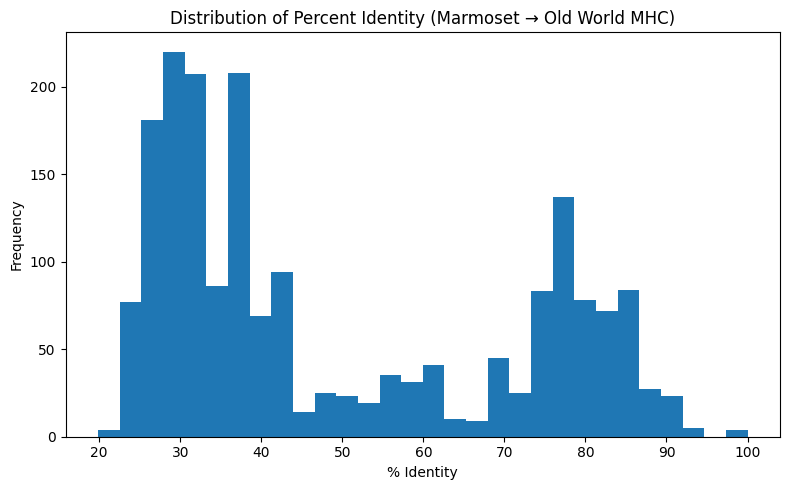

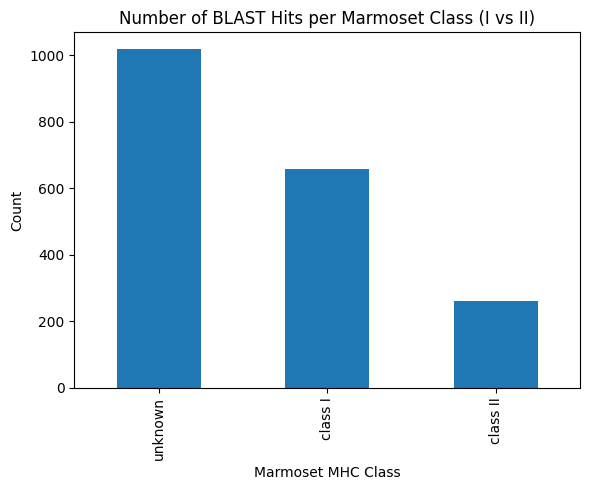

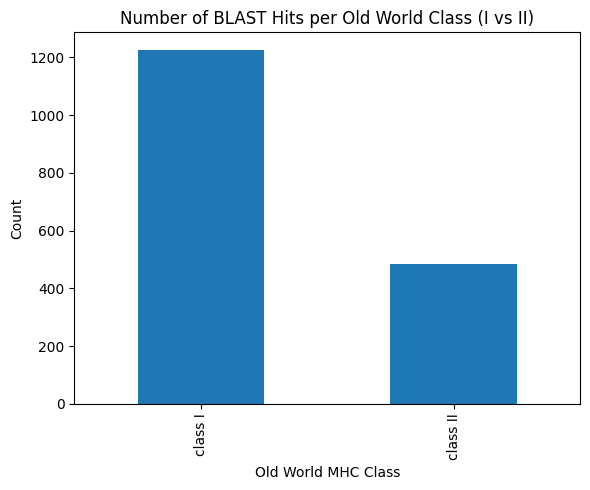

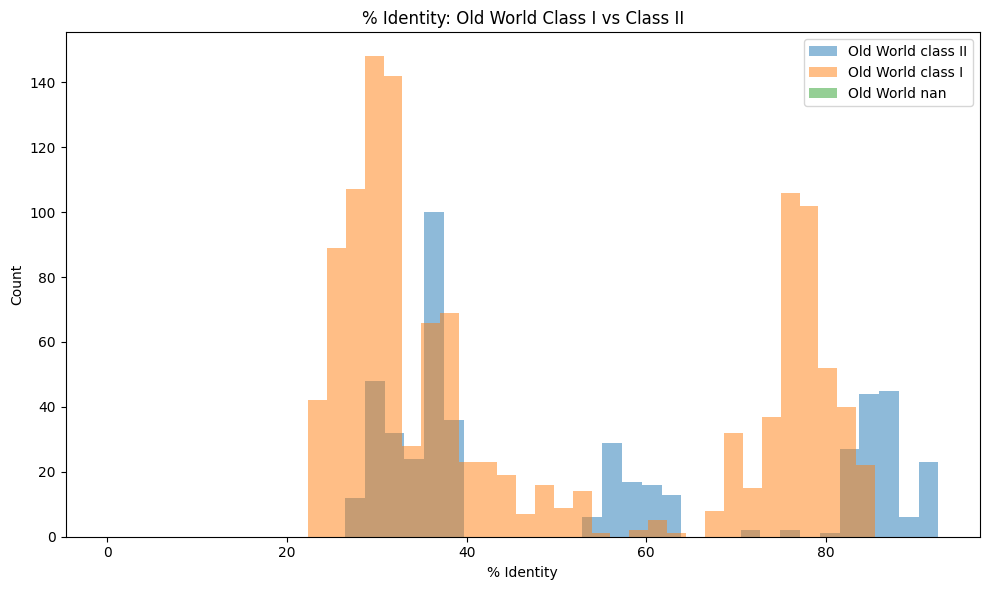

<Figure size 800x600 with 0 Axes>

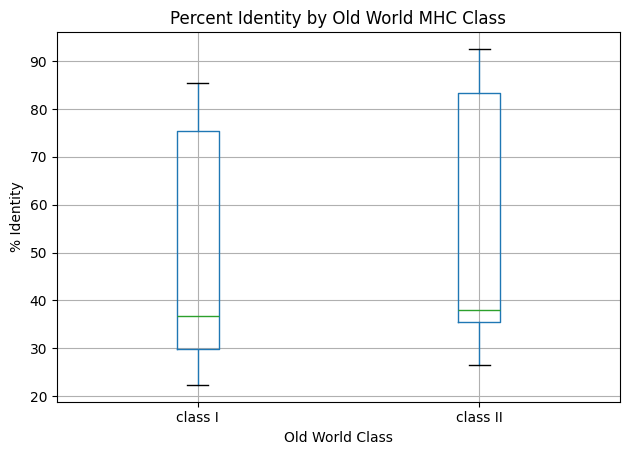

<Figure size 800x600 with 0 Axes>

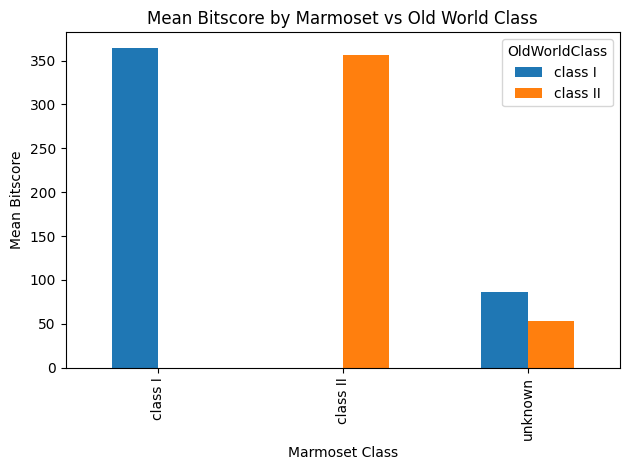

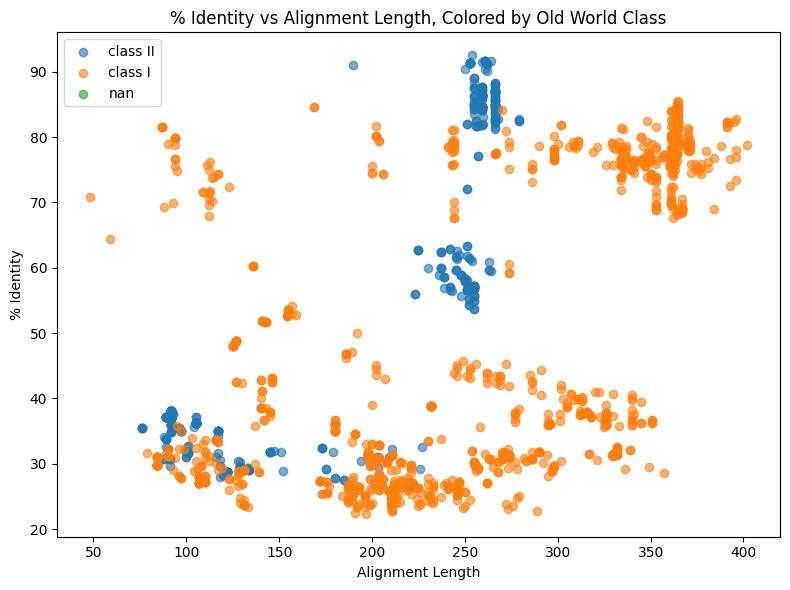

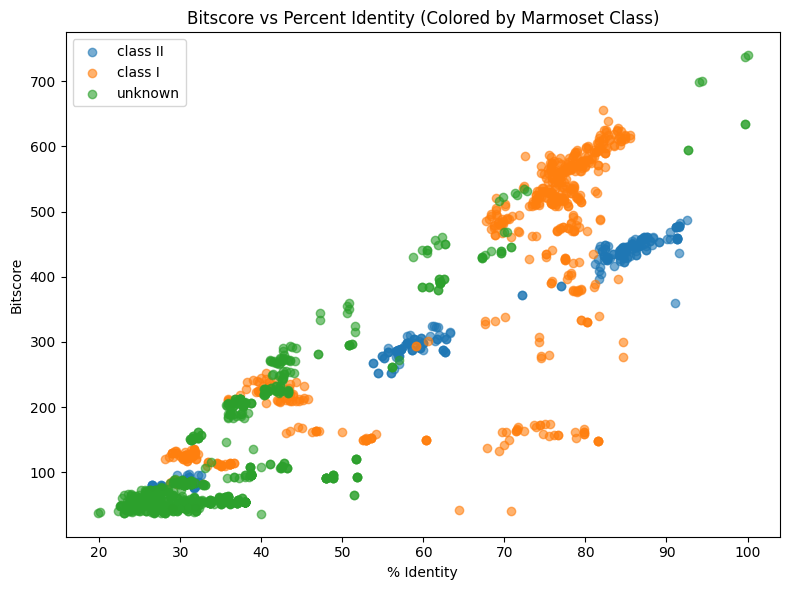

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Create a directory to save figures
output_dir = "output_figures"
os.makedirs(output_dir, exist_ok=True)

# -----------------------------
# Load final annotated TSV file
# -----------------------------
df = pd.read_csv(
    "/content/A-Final-GeneID-Marmoset_vs_OldWorldMHC_withClasses_Annotated.tsv",
    sep="\t",
    header=0
)

print(df.head())
print(df.columns)

# ============================================================
# 1. Histogram of Percent Identity (pident)
# ============================================================

plt.figure(figsize=(8,5))
plt.hist(df["pident"], bins=30)
plt.title("Distribution of Percent Identity (Marmoset \u2192 Old World MHC)")
plt.xlabel("% Identity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pident_histogram.png"))
plt.show()


# ============================================================
# 2. Barplot: Number of Hits per Marmoset Class (Class I vs Class II)
# ============================================================

plt.figure(figsize=(6,5))
df["MarmosetClass"].value_counts().plot(kind="bar")
plt.title("Number of BLAST Hits per Marmoset Class (I vs II)")
plt.xlabel("Marmoset MHC Class")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "marmoset_class_barplot.png"))
plt.show()


# ============================================================
# 3. Barplot: Number of Hits per Old World Class
# ============================================================

plt.figure(figsize=(6,5))
df["OldWorldClass"].value_counts().plot(kind="bar")
plt.title("Number of BLAST Hits per Old World Class (I vs II)")
plt.xlabel("Old World MHC Class")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "oldworld_class_barplot.png"))
plt.show()


# ============================================================
# 4. Class I vs Class II: Percent Identity Distributions
# ============================================================

plt.figure(figsize=(10,6))
for cls in df["OldWorldClass"].unique():
    subset = df[df["OldWorldClass"] == cls]
    plt.hist(subset["pident"], bins=30, alpha=0.5, label=f"Old World {cls}")

plt.title("% Identity: Old World Class I vs Class II")
plt.xlabel("% Identity")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pident_distribution_by_oldworld_class.png"))
plt.show()


# ============================================================
# 5. Boxplot: pident by Old World Class
# ============================================================

plt.figure(figsize=(8,6))
df.boxplot(column="pident", by="OldWorldClass")
plt.title("Percent Identity by Old World MHC Class")
plt.suptitle("")  # removes default matplotlib title
plt.xlabel("Old World Class")
plt.ylabel("% Identity")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pident_boxplot_by_oldworld_class.png"))
plt.show()


# ============================================================
# 6. Mean bitscore by Marmoset Class and Old World Class
# ============================================================

bitscore_means = df.groupby(["MarmosetClass", "OldWorldClass"])["bitscore"].mean().unstack()

plt.figure(figsize=(8,6))
bitscore_means.plot(kind="bar")
plt.title("Mean Bitscore by Marmoset vs Old World Class")
plt.xlabel("Marmoset Class")
plt.ylabel("Mean Bitscore")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "mean_bitscore_by_class.png"))
plt.show()


# ============================================================
# 7. Scatterplot: % Identity vs Alignment Length, colored by Old World Class
# ============================================================

plt.figure(figsize=(8,6))
for cls in df["OldWorldClass"].unique():
    subset = df[df["OldWorldClass"] == cls]
    plt.scatter(subset["length"], subset["pident"], alpha=0.6, label=cls)

plt.title("% Identity vs Alignment Length, Colored by Old World Class")
plt.xlabel("Alignment Length")
plt.ylabel("% Identity")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pident_vs_length_scatterplot.png"))
plt.show()


# ============================================================
# 8. Scatterplot: Bitscore vs % Identity (colored by Marmoset class)
# ============================================================

plt.figure(figsize=(8,6))
for cls in df["MarmosetClass"].unique():
    subset = df[df["MarmosetClass"] == cls]
    plt.scatter(subset["pident"], subset["bitscore"], alpha=0.6, label=cls)

plt.title("Bitscore vs Percent Identity (Colored by Marmoset Class)")
plt.xlabel("% Identity")
plt.ylabel("Bitscore")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "bitscore_vs_pident_scatterplot.png"))
plt.show()